In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")
%matplotlib inline

In [2]:
import plotly.offline as py
py.init_notebook_mode(connected=False)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import cufflinks as cf
cf.set_config_file(offline=False, world_readable=True, theme='ggplot')

# Feature Engineering

In this notebook we will explore a key part of data science, **feature engineering**: _the process of transforming the representation of model inputs to enable better model approximation._  Feature engineering enables you to:

1. **encode** non-numeric features to be used as inputs to common numeric models
1. capture **domain knowledge** (e.g., the perceived loudness or sound is the log of the intensity)
1. **transform** complex relationships into simple linear relationships



## Mapping from Domain to Range

In the supervised learning setting were are given $(X,Y)$ pairs with the goal of learning the mapping from $X$ to $Y$. For example, given pairs of square footage and price we want to learn a function that captures (or at least approximates) the relationship between square feet and price.  Our functional approximation is some form of typically parametric mapping from some **domain** to some **range**:

<img src="images/domain_range.png" width="400px"> 

In this class we will focus on **Multiple Regression** in which we consider mappings from potentially high-dimensional input spaces onto the real line (i.e., $y \in \mathbb{R}$):

<img src="images/domain_real_range.png" width="400px">

It is worth noting that this is distinct from **Multivariate Regression** in which we are predicting multiple (confusing?) response values (e.g., $y \in \mathbb{R}^q$).



# Not all Domains are Quantitative

Suppose we are given the following table:

<img src="images/input_table.png" width="600px">

Our goal is to learn a function that approximates the relationship between the blue and red columns.  Let's assume the range, `"Ratings"`, are the real numbers (this may be a problem if ratings are between [0, 5] but more on that later).

**What is the _domain_ of this function?**



The schema of the relational model provides one possible answer:

```SQL
RatingsData(uid INTEGER, age FLOAT, 
            state VARCHAR, hasBought BOOLEAN,
            review VARCHAR, rating FLOAT)
```

Which would suggest that the domain is then:

> integers, real numbers, strings, booleans, and more strings.

Unfortunately, the techniques we have discussed so far and most of the techniques in machine learning and statistics operate on real-valued vector inputs $x \in \mathbb{R}^d$ (or for the statisticians $x \in \mathbb{R}^p$). 

## Goal: 

<img src="images/real_domain_range.png" width="400px">




Moreover, many of these techniques, especially the linear models we have been studying, assume the inputs are **qauntitative** variables in which the relative magnitude of the feature encode information about the response variable. 

In the following we define several basic transformations to encode features as real numbers.

# Basic Feature Engineering:  _Get $\mathbb{R}$_

Our first step as feature engineers is to translate our data into a form that encodes each feature as a continuous variable.

## The _Uninformative_  Feature: `uid`

The `uid` was likely used to join the user information (e.g., `age`, and `state`) with some `Reviews` table.  The `uid` presents several questions:
* What is the meaning of the `uid` *number*? 
* Does the magnitude of the `uid` reveal information about the rating? 

There are several answers:

1. Although numbers, identifiers are **typically categorical** (like strings) and as a consequence the magnitude has little meaning.  In these settings we would either **drop** or **one-hot encode** the `uid`.  We will return to feature dropping and one-hot-encoding in a moment.

1. There are scenarios where the magnitude of the numerical `uid` value contains important information. When user ids are created in consecutive order, larger user ids would imply more recent users.  In these cases we might to interpret the `uid` feature as a real number and keep it in our model.

## Dropping Features

While uncommon there are certain scenarios where manually dropping features might be helpful:

1. when the features **does not to contain information** associated with the prediction task.  Dropping uninformative features can help to address over-fitting, an issue we will discuss in great detail soon.  

1. when the feature is **not available at prediction time.**  For example, the feature might contain information collected after the user entered a rating.  This is a common scenario in time-series analysis.

However, in the absence of substantial domain knowledge, we would prefer to use algorithmic techniques to help eliminate features.  We will discuss this in more detail when we return to regularization.

## The _Continuous_ `age` Feature

The `age` feature encodes the users age.  This is already a continuous real number so no additional feature transformations are required.  However, as we will soon see, we may introduce additional related features (e.g., indicators for various age groups or non-linear transformations).



## The _Categorical_ `state` Feature

The `state` feature is a string encoding the category (one of the 50 states).  How do we meaningfully encode such a feature as one or more real-numbers?

We could enumerate the states in alphabetical order `AL=0`, `AK=2`, ... `WY=49`.  This is a form of **dictionary encoding** which maps each category to an integer.  However, this would likely be a poor feature encoding since the magnitude provides little information about the rating.  

Alternatively, we might enumerate the states based on their geographic region (e.g., lower numbers for coastal states.). While this alternative dictionary encoding may provide information there is better way to encode categorical features for machine learning algorithms.



# One-Hot Encoding

<img src="images/one_hot_state.png" width="600px">

One-Hot encoding, sometimes also called **dummy encoding** is a simple mechanism to encode categorical data as real numbers such that the magnitude of each dimension is meaningful.  Suppose a feature can take on $k$ distinct values (e.g., $k=50$ for 50 states in the United Stated).  For each distinct _possible_ value a new feature (dimension) is created.  For each record, all the new features are set to zero except the one corresponding to the value in the original feature. 

The term one-hot encoding comes from a digital circuit encoding of a categorical state as particular "hot" wire:

<img src="images/one_hot_encoding.png" width="400px">

## One-Hot Encoding in Pandas

Here we create a toy DataFrame of pets including their name and kind:

In [3]:
df = pd.DataFrame({
    "name": ["Goldy", "Scooby", "Brian", "Francine", "Goldy"],
    "kind": ["Fish", "Dog", "Dog", "Cat", "Dog"],
    "age": [0.5, 7., 3., 10., 1.]
}, columns = ["name", "kind", "age"])

name  kind   age
0     Goldy  Fish   0.5
1    Scooby   Dog   7.0
2     Brian   Dog   3.0
3  Francine   Cat  10.0
4     Goldy   Dog   1.0

Pandas has a built in function to construct one-hot encodings called [**`get_dummies`**](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html#pandas.get_dummies)

In [4]:
pd.get_dummies(df['kind'])

Cat  Dog  Fish
0    0    0     1
1    0    1     0
2    0    1     0
3    1    0     0
4    0    1     0

In [5]:
pd.get_dummies(df)

age  name_Brian  name_Francine  name_Goldy  name_Scooby  kind_Cat  \
0   0.5           0              0           1            0         0   
1   7.0           0              0           0            1         0   
2   3.0           1              0           0            0         0   
3  10.0           0              1           0            0         1   
4   1.0           0              0           1            0         0   

   kind_Dog  kind_Fish  
0         0          1  
1         1          0  
2         1          0  
3         0          0  
4         1          0

A serious issue with using Pandas to construct a one-hot-encoding is that we have no easy way to apply an old one-hot encoding to new data. For example, we can't somehow apply the same encoding from above for df2 below.

In [18]:
df2 = pd.DataFrame({
    "name": ["Goldy", "Fluffy", "Goldy"],
    "kind": ["Cat", "Bird", "Chihuahua"],
    "age": [35, None, None]
}, columns = ["name", "kind", "age"])
df2

name       kind   age
0   Goldy        Cat  35.0
1  Fluffy       Bird   NaN
2   Goldy  Chihuahua   NaN

## One-Hot Encoding in Scikit-Learn

Scikit-Learn also has several library for constructing one-hot-encodings that rely on a DataFrame method called `to_dict`.

In [8]:
df.to_dict(orient='records')

[{'age': 0.5, 'kind': 'Fish', 'name': 'Goldy'},
 {'age': 7.0, 'kind': 'Dog', 'name': 'Scooby'},
 {'age': 3.0, 'kind': 'Dog', 'name': 'Brian'},
 {'age': 10.0, 'kind': 'Cat', 'name': 'Francine'},
 {'age': 1.0, 'kind': 'Dog', 'name': 'Goldy'}]

In [9]:
from sklearn.feature_extraction import DictVectorizer

vec_enc = DictVectorizer()
vec_enc.fit(df.to_dict(orient='records'))

DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=True)

In [10]:
vec_enc.transform(df.to_dict(orient='records')).toarray()

array([[  0.5,   0. ,   0. ,   1. ,   0. ,   0. ,   1. ,   0. ],
       [  7. ,   0. ,   1. ,   0. ,   0. ,   0. ,   0. ,   1. ],
       [  3. ,   0. ,   1. ,   0. ,   1. ,   0. ,   0. ,   0. ],
       [ 10. ,   1. ,   0. ,   0. ,   0. ,   1. ,   0. ,   0. ],
       [  1. ,   0. ,   1. ,   0. ,   0. ,   0. ,   1. ,   0. ]])

In [11]:
vec_enc.get_feature_names()

['age',
 'kind=Cat',
 'kind=Dog',
 'kind=Fish',
 'name=Brian',
 'name=Francine',
 'name=Goldy',
 'name=Scooby']

### Applying to new data

One advantage of the `DictVectorizer` in *sklearn* is that we can easily apply it to new data:


In [20]:
vec_enc.transform(df2.to_dict(orient='records')).toarray()

array([[ 35.,   1.,   0.,   0.,   0.,   0.,   1.,   0.],
       [ nan,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [ nan,   0.,   0.,   0.,   0.,   0.,   1.,   0.]])

# The _Text_ `review` Feature

Encoding text as a real-valued feature is especially challenging and many of the standard transformations are **lossy**. Moreover, all of the earlier transformations (e.g., one-hot encoding and Boolean representations) preserve the information in the feature. In contrast, most of the techniques for encoding text destroy information about the word order and in many cases key parts of the grammar.  

Here we will discuss two widely used representations of text:

* **Bag-of-Words Encoding**: encodes text by the frequency of each word
* **N-Gram Encoding**: encodes text by the frequency of sequences of words of length $N$

Both of these encoding strategies are related to the one-hot encoding with dummy features created for every word or sequence of words and with multiple dummy features having counts greater than zero.



## The Bag-of-Words Encoding


The bag-of-words encoding is widely used and a standard representation for text in many of the popular text clustering algorithms.  The following is a simple illustration of the bag-of-words encoding:

<img src="images/bag_of_words.png" width="600px">

**Notice**
1. **Stop words are removed.** Stop-words are words like `is` and `about` that in isolation contain very little information about the meaning of the sentence.  Here is a good list of [stop-words in many languages](https://code.google.com/archive/p/stop-words/). 
1. **Word order information is lost.**  Nonetheless the vector still suggests that the sentence is about `fun`, `machines`, and `learning`.  Thought there are many possible meanings _learning machines have fun learning_ or _learning about machines is fun learning_ ...
1. **Capitalization and punctuation are typically removed.**  
1. **Sparse Encoding:** is necessary to represent the bag-of-words efficiently.  There are millions of possible words (including terminology, names, and misspellings) and so instantiating a `0` for every word that is not in each record would be incredibly inefficient.  

**Why is it called a bag-of-words?**  A bag is another term for a **multiset**: _an unordered 
collection which may contain multiple instances of each element._  

### Implementing the Bag-of-words Model

We can use sklearn to construct a bag-of-words representation of text

In [21]:
frost_text = [x for x in """
Some say the world will end in fire,
Some say in ice.
From what Ive tasted of desire
I hold with those who favor fire.
""".split("\n") if len(x) > 0]

frost_text

['Some say the world will end in fire,',
 'Some say in ice.',
 'From what Ive tasted of desire',
 'I hold with those who favor fire.']

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

# Construct the tokenizer with English stop words
bow = CountVectorizer(stop_words="english")

# fit the model to the passage
bow.fit(frost_text)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [23]:
# Print the words that are kept
print("Words:", list(enumerate(bow.get_feature_names())))

Words: [(0, 'desire'), (1, 'end'), (2, 'favor'), (3, 'hold'), (4, 'ice'), (5, 'ive'), (6, 'say'), (7, 'tasted'), (8, 'world')]


In [24]:
print("Sentence Encoding: \n")
# Print the encoding of each line
for (s, r) in zip(frost_text, bow.transform(frost_text)):
    print(s)
    print(r)
    print("------------------")

Sentence Encoding: 

Some say the world will end in fire,
  (0, 1)	1
  (0, 6)	1
  (0, 8)	1
------------------
Some say in ice.
  (0, 4)	1
  (0, 6)	1
------------------
From what Ive tasted of desire
  (0, 0)	1
  (0, 5)	1
  (0, 7)	1
------------------
I hold with those who favor fire.
  (0, 2)	1
  (0, 3)	1
------------------


## The N-Gram Encoding

The N-Gram encoding is a generalization of the bag-of-words encoding designed to capture limited ordering information.  Consider the following passage of text:

> _The book was not well written but I did enjoy it._

If we re-arrange the words we can also write:

> _The book was well written but I did not enjoy it._

Moreover, local word order can be important when making decisions about text.  The n-gram encoding captures local word order by defining counts over sliding windows. In the following example a bi-gram ($n=2$) encoding is constructed:

<img src="images/ngram.png" width="800px">

The above n-gram would be encoded in the sparse vector:

<img src="images/ngram_vector.png" width="300px">

Notice that the n-gram captures key pieces of sentiment information: `"well written"` and `"not enjoy"`.  

N-grams are often used for other types of sequence data beyond text. For example, n-grams can be used to encode genomic data, protein sequences, and click logs. 

**N-Gram Issues**
1. The n-gram representation is hyper sparse and maintaining the dictionary of possible n-grams can be very costly.  The **hashing trick** is a popular solution to approximate the sparse n-gram encoding.  In the hashing trick each n-gram is mapped to a relatively large (e.g., 32bit) hash-id and the counts are associated with the hash index without saving the n-gram text in a dictionary.  As a consequence, multiple n-grams are treated as the same.
1. As $N$ increase the chance of seeing the same n-grams at prediction time decreases rapidly.

In [25]:
# Construct the tokenizer with English stop words
bigram = CountVectorizer(ngram_range=(1, 2))
# fit the model to the passage
bigram.fit(frost_text)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [26]:
# Print the words that are kept
print("\nWords:", 
      list(zip(range(0,len(bigram.get_feature_names())), bigram.get_feature_names())))


Words: [(0, 'desire'), (1, 'end'), (2, 'end in'), (3, 'favor'), (4, 'favor fire'), (5, 'fire'), (6, 'from'), (7, 'from what'), (8, 'hold'), (9, 'hold with'), (10, 'ice'), (11, 'in'), (12, 'in fire'), (13, 'in ice'), (14, 'ive'), (15, 'ive tasted'), (16, 'of'), (17, 'of desire'), (18, 'say'), (19, 'say in'), (20, 'say the'), (21, 'some'), (22, 'some say'), (23, 'tasted'), (24, 'tasted of'), (25, 'the'), (26, 'the world'), (27, 'those'), (28, 'those who'), (29, 'what'), (30, 'what ive'), (31, 'who'), (32, 'who favor'), (33, 'will'), (34, 'will end'), (35, 'with'), (36, 'with those'), (37, 'world'), (38, 'world will')]


In [27]:
print("\nSentence Encoding: \n")
# Print the encoding of each line
for (s, r) in zip(frost_text, bigram.transform(frost_text)):
    print(s)
    print(r)
    print("------------------")


Sentence Encoding: 

Some say the world will end in fire,
  (0, 1)	1
  (0, 2)	1
  (0, 5)	1
  (0, 11)	1
  (0, 12)	1
  (0, 18)	1
  (0, 20)	1
  (0, 21)	1
  (0, 22)	1
  (0, 25)	1
  (0, 26)	1
  (0, 33)	1
  (0, 34)	1
  (0, 37)	1
  (0, 38)	1
------------------
Some say in ice.
  (0, 10)	1
  (0, 11)	1
  (0, 13)	1
  (0, 18)	1
  (0, 19)	1
  (0, 21)	1
  (0, 22)	1
------------------
From what Ive tasted of desire
  (0, 0)	1
  (0, 6)	1
  (0, 7)	1
  (0, 14)	1
  (0, 15)	1
  (0, 16)	1
  (0, 17)	1
  (0, 23)	1
  (0, 24)	1
  (0, 29)	1
  (0, 30)	1
------------------
I hold with those who favor fire.
  (0, 3)	1
  (0, 4)	1
  (0, 5)	1
  (0, 8)	1
  (0, 9)	1
  (0, 27)	1
  (0, 28)	1
  (0, 31)	1
  (0, 32)	1
  (0, 35)	1
  (0, 36)	1
------------------


## Calculating Optimal Theta

We'll give an example here of how to compute the optimal Theta for linear models. For conceptual simplicity, we will use data with only one dimension, and our feature functions will be extremely simple.

In [36]:
train_data = pd.read_csv("data/toy_training_data.csv")
train_data.head()

X          Y
0 -9.889558  12.778085
1 -9.588310   9.888070
2 -9.312230   4.183466
3 -9.095454   0.940616
4 -9.070992  -2.349544

In [37]:
# Visualize the data ---------------------
train_points = go.Scatter(name = "Training Data", 
                          x = train_data['X'], y = train_data['Y'], 
                          mode = 'markers')
# layout = go.Layout(autosize=False, width=800, height=600)
py.iplot(go.Figure(data=[train_points]))

# Solving the Normal Equations

## Extracting the Data as Matrices

In [38]:
# Note that we select a list of columns to return a matrix (n,p)
X = train_data[['X']].values
print("X shape:", X.shape)

Y = train_data['Y'].values
print("Y shape:", Y.shape)

X shape: (75, 1)
Y shape: (75,)


## Adding a Bias Column

Below, we add a second column to our feature matrix, all equal to 1. This corresponds to a fixed bias that is applied to all data pints. Equivalently, you can think of our feature functions as:

$$\phi_1(x) = x$$
$$\phi_2(x) = 1$$

In [40]:
Phi = np.hstack([X, np.ones((len(X), 1))])
Phi[1:5,:]

array([[-9.58831011,  1.        ],
       [-9.31222958,  1.        ],
       [-9.09545422,  1.        ],
       [-9.07099175,  1.        ]])

## Solving for $\hat{\theta{}}$

There are multiple ways to solve for $\hat{\theta{}}$. Following the solution to the normal equations:

$$\large
 \hat{\theta{}} = \left(\Phi^T  \Phi\right)^{-1} \Phi^T Y
$$

we get:

In [42]:
theta_hat = np.linalg.inv(Phi.T @ Phi) @ Phi.T @ Y
theta_hat

array([  1.63923611,  20.54032661])

However computing inverting and multiplying (i.e., solving) can be accomplished with a special routine more efficiently:

$$\large
A^{-1}b = \texttt{solve}(A, b)
$$

In [43]:
theta_hat = np.linalg.solve(Phi.T @ Phi, Phi.T @ Y)
theta_hat

array([  1.63923611,  20.54032661])

Given our theta, we can now compute predictions for each X.

In [90]:
y_hat = Phi @ theta_hat
y_hat

array([  4.32900655,   4.8228224 ,   5.27538359,   5.63072958,
         5.67082936,   6.05222057,   6.28066389,   6.59208762,
         7.04916758,   7.35011861,   8.14895511,   8.72123296,
         8.76812705,   9.2622025 ,   9.26299327,   9.73855151,
        10.10904653,  10.1608314 ,  10.20836746,  10.57320919,
        10.66280391,  10.69421497,  11.10944425,  12.6319953 ,
        13.04406812,  13.35832535,  13.69583196,  13.72584664,
        14.12246292,  14.1346433 ,  14.36732654,  14.81383002,
        15.84402421,  16.15903676,  16.42715925,  16.89064247,
        18.30916295,  18.57824274,  19.10009325,  20.38220295,
        21.00699872,  21.19825111,  21.35195935,  21.94010584,
        22.07171015,  23.57011259,  23.74995023,  23.77481762,
        23.85535419,  24.06615471,  24.2073927 ,  25.86857457,
        26.58035522,  27.32208718,  27.36192829,  28.14618356,
        29.46579577,  29.56047982,  29.88974131,  30.4477707 ,
        30.65104802,  30.88264193,  31.31789455,  31.43

And manually comparing these to our original data:

In [89]:
Y

array([ 12.77808546,   9.88806956,   4.18346579,   0.94061596,
        -2.34954422,   5.05719424,  -0.30792839,  -2.13026809,
         2.48299165,  -5.02870897,   2.01417238,   2.22492761,
        -2.22755631,   3.7935094 ,   7.46890893,   9.88467142,
        14.8864786 ,  11.19871749,  22.15142752,   9.67266224,
        27.        ,  13.50864018,  11.45959989,   2.        ,
        26.20587232,  22.95145739,  20.45903323,  17.02916925,
        18.35174677,  23.6749339 ,  40.        ,  16.71175723,
        14.7262349 ,  15.52608446,  11.22532944,   9.83464379,
        12.97892707,   9.50971527,   9.90112648,  21.24812383,
        22.33741512,  23.22136075,  29.95220902,  27.79767668,
        20.14946308,  33.59919666,  30.81237912,  31.14911725,
        33.61664686,  31.00920691,  31.96924972,  16.71118432,
        17.05864284,  22.72896977,  17.65690784,   2.        ,
        16.97847548,  17.74338027,  23.43604979,  25.18207823,
        25.79494783,  29.7380266 ,  34.40877869,  32.64

It's hard to see how well we did, so let's turn to visualization.

### Visualizing the fit 

To visualize the fit line we will make a set of predictions at 10 evenly spaced points.

In [77]:
X_query = np.linspace(train_data['X'].min()-1, train_data['X'].max() +1, 1000)
Phi_query = np.hstack([X_query[:,np.newaxis], np.ones((len(X_query),1))])
y_query_pred = Phi_query @ theta_hat

We can then plot the residuals along with the line.

In [78]:
# Define the least squares regression line 
basic_line = go.Scatter(name = r"Linear Model", x=X_query, y = y_query_pred)

# Definethe residual lines segments, a separate line for each 
# training point
residual_lines = [
    go.Scatter(x=[x,x], y=[y,yhat],
               mode='lines', showlegend=False, 
               line=dict(color='black', width = 0.5))
    for (x, y, yhat) in zip(train_data['X'], train_data['Y'], y_hat)
]

# Combine the plot elements
py.iplot([train_points, basic_line] + residual_lines)

## Examining the Residuals

It is often helpful to examine the residuals.  Ideally the residuals should be normally distributed.

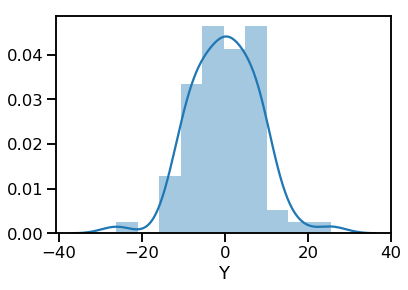

In [79]:
residuals = train_data['Y'] - y_hat
sns.distplot(residuals)
# plt.savefig("residuals.pdf")

We might also plot $\hat{Y}$ vs $Y$.  Ideally, the data should be along the diagonal.

In [80]:
# Plot.ly plotting code
py.iplot(go.Figure(
    data = [go.Scatter(x=train_data['Y'], y=y_hat, mode='markers', name="Points"),
            go.Scatter(x=[-10, 50], y = [-10, 50], line=dict(color='black'), 
                       name="Diagonal", mode='lines')],
    layout = dict(title=r"Y_hat vs Y Plot", xaxis=dict(title="Y"), 
                  yaxis=dict(title=r"$\hat{Y}$"))
))


The sum of the residuals should be?

In [81]:
np.sum(residuals)

6.0396132539608516e-14

## Using a Package to estimate the linear model

In practice, it is generally better to use specialized software packages for linear regression.  In Python, [scikit-learn](http://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares) is the standard package for regression.  

![scikit-learn logo](http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png)

Here we will take a very brief tour of how to use scikit-learn for regression.  Over the next few weeks we will use scikit-learn for a range of different task.

You can use the the [scikit-learn `linear_model` package](http://scikit-learn.org/stable/modules/linear_model.html) to compute the normal equations. This package supports a wide range of **generalized linear models**.  For those who are interested in studying machine learning, I would encourage you to skim through the descriptions of the various models in the `linear_model` package. These are the foundation of most practical applications of supervised machine learning.

In [82]:
from sklearn import linear_model

**Intercept Term**  Scikit-learn can automatically add the intercept term.  This can be helpful since you don't need to remember to add it later when making a prediction.  In the following we create a model object.

In [83]:
line_reg = linear_model.LinearRegression(fit_intercept=True)

We can then fit the model in one line (this solves the normal equations.

In [84]:
# Fit the model to the data
line_reg.fit(train_data[['X']], train_data['Y'])
np.hstack([line_reg.coef_, line_reg.intercept_]) 

array([  1.63923611,  20.54032661])

In [91]:
y_hat_sklearn = line_reg.predict(train_data[['X']])
y_hat_sklearn

array([  4.32900655,   4.8228224 ,   5.27538359,   5.63072958,
         5.67082936,   6.05222057,   6.28066389,   6.59208762,
         7.04916758,   7.35011861,   8.14895511,   8.72123296,
         8.76812705,   9.2622025 ,   9.26299327,   9.73855151,
        10.10904653,  10.1608314 ,  10.20836746,  10.57320919,
        10.66280391,  10.69421497,  11.10944425,  12.6319953 ,
        13.04406812,  13.35832535,  13.69583196,  13.72584664,
        14.12246292,  14.1346433 ,  14.36732654,  14.81383002,
        15.84402421,  16.15903676,  16.42715925,  16.89064247,
        18.30916295,  18.57824274,  19.10009325,  20.38220295,
        21.00699872,  21.19825111,  21.35195935,  21.94010584,
        22.07171015,  23.57011259,  23.74995023,  23.77481762,
        23.85535419,  24.06615471,  24.2073927 ,  25.86857457,
        26.58035522,  27.32208718,  27.36192829,  28.14618356,
        29.46579577,  29.56047982,  29.88974131,  30.4477707 ,
        30.65104802,  30.88264193,  31.31789455,  31.43

These are, of course, almost the same as our values predicted just using the normal equation.

In [95]:
y_hat

array([  4.32900655,   4.8228224 ,   5.27538359,   5.63072958,
         5.67082936,   6.05222057,   6.28066389,   6.59208762,
         7.04916758,   7.35011861,   8.14895511,   8.72123296,
         8.76812705,   9.2622025 ,   9.26299327,   9.73855151,
        10.10904653,  10.1608314 ,  10.20836746,  10.57320919,
        10.66280391,  10.69421497,  11.10944425,  12.6319953 ,
        13.04406812,  13.35832535,  13.69583196,  13.72584664,
        14.12246292,  14.1346433 ,  14.36732654,  14.81383002,
        15.84402421,  16.15903676,  16.42715925,  16.89064247,
        18.30916295,  18.57824274,  19.10009325,  20.38220295,
        21.00699872,  21.19825111,  21.35195935,  21.94010584,
        22.07171015,  23.57011259,  23.74995023,  23.77481762,
        23.85535419,  24.06615471,  24.2073927 ,  25.86857457,
        26.58035522,  27.32208718,  27.36192829,  28.14618356,
        29.46579577,  29.56047982,  29.88974131,  30.4477707 ,
        30.65104802,  30.88264193,  31.31789455,  31.43

## Using Feature Functions to Improve Our MOdel

### Plotting against dimensions in X

When plotted against any one dimension we don't want to see any patterns:

In [98]:
# Plot.ly plotting code
py.iplot(go.Figure(
    data = [go.Scatter(x=train_data['X'], y=residuals, mode='markers')],
    layout = dict(title="Residual Plot", xaxis=dict(title="X"), 
                  yaxis=dict(title="Residual"))
))


---
<br/><br/><br/>

# Transforming the Toy Data

In our toy data set we observed a cyclic pattern.  Here we construct a $\phi$ to capture the cyclic nature of our data and visualize the corresponding hyperplane.


In the following cell we define a function $\phi$ that maps $x\in \mathbb{R}$ to the vector $[x,\sin(x)] \in \mathbb{R}^2$ 

$$ \large
\phi(x) = [x, \sin(x)]
$$

**Why not:**

$$ \large
\phi(x) = [x, \sin(\theta_3 x + \theta_4)]
$$

This would no longer be linear $\theta$.  However, in practice we might want to consider a range of $\sin$ basis:

$$ \large
\phi_{\alpha,\beta}(x) = \sin(\alpha x + \beta)
$$

for different values of $\alpha$ and $\beta$.  The parameters $\alpha$ and $\beta$ are typically called **hyperparameters** because (at least in this setting) they are not set automatically through learning.



In [99]:
def sin_phi(x):
    return np.hstack([x, np.sin(x)])

In [100]:
Phi = sin_phi(train_data[["X"]])
Phi[:5]

array([[-9.88955766,  0.44822588],
       [-9.58831011,  0.16280424],
       [-9.31222958, -0.11231092],
       [-9.09545422, -0.32340318],
       [-9.07099175, -0.34645201]])

# Fit a _Linear Model_ on $\Phi$

We can again use the scikit-learn package to fit a linear model on the transformed space.

## Fitting the Basic Linear Model

In [101]:
from sklearn import linear_model
basic_reg = linear_model.LinearRegression(fit_intercept=True)
basic_reg.fit(train_data[['X']], train_data['Y'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

## Fitting the Transformed Linear Model on $\Phi$

In [102]:
from sklearn import linear_model
sin_reg = linear_model.LinearRegression(fit_intercept=True)
sin_reg.fit(sin_phi(train_data[["X"]]), train_data['Y'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

## Making Predictions at Query Locations

In [103]:
X_query = np.linspace(train_data['X'].min()-1, train_data['X'].max() +1, 100)
Y_basic_query = basic_reg.predict(X_query[:, np.newaxis])
Y_sin_query = sin_reg.predict(sin_phi(X_query[:, np.newaxis]))

## Visualizing the Fit

In [104]:
# Define the least squares regression line 
basic_line = go.Scatter(name = r"Basic Model", x=X_query, y = Y_basic_query)
sin_line = go.Scatter(name = r"Transformed Model", x=X_query, y = Y_sin_query)

# Definethe residual lines segments, a separate line for each 
# training point
residual_lines = [
    go.Scatter(x=[x,x], y=[y,yhat],
               mode='lines', showlegend=False, 
               line=dict(color='black', width = 0.5))
    for (x, y, yhat) in zip(train_data['X'], train_data['Y'], 
                            sin_reg.predict(sin_phi(train_data[["X"]])))
]

# Combine the plot elements
py.iplot([train_points, basic_line, sin_line] + residual_lines)

# Linear Model in a Transformed Space

As discussed earlier the model we just constructed, while non-linear in $x$ is actually a linear model in $\phi(x)$ and we can visualize that linear model's structure in higher dimensions.

In [105]:
# Plot the data in higher dimensions
phi3d = go.Scatter3d(name = "Raw Data",
    x = Phi[:,0], y = Phi[:,1], z = train_data['Y'],
    mode = 'markers',
    marker = dict(size=3),
    showlegend=False
)

# Compute the predictin plane
(u,v) = np.meshgrid(np.linspace(-10,10,5), np.linspace(-1,1,5))
coords = np.vstack((u.flatten(),v.flatten())).T
ycoords = sin_reg.predict(coords)
fit_plane = go.Surface(name = "Fitting Hyperplane",
    x = np.reshape(coords[:,0], (5,5)),
    y = np.reshape(coords[:,1], (5,5)),
    z = np.reshape(ycoords, (5,5)),
    opacity = 0.8, cauto = False, showscale = False,
    colorscale = [[0, 'rgb(255,0,0)'], [1, 'rgb(255,0,0)']]
)

# Construct residual lines
Yhat = sin_reg.predict(Phi)
residual_lines = [
    go.Scatter3d(x=[x[0],x[0]], y=[x[1],x[1]], z=[y, yhat],
                 mode='lines', showlegend=False, 
                 line=dict(color='black'))
    for (x, y, yhat) in zip(Phi, train_data['Y'], Yhat)
]

    
# Label the axis and orient the camera
layout = go.Layout(
    scene=go.Scene(
        xaxis=go.XAxis(title='X'),
        yaxis=go.YAxis(title='sin(X)'),
        zaxis=go.ZAxis(title='Y'),
        aspectratio=dict(x=1.,y=1., z=1.), 
        camera=dict(eye=dict(x=-1, y=-1, z=0))
    )
)

py.iplot(go.Figure(data=[phi3d, fit_plane] + residual_lines, layout=layout))

# Error Estimates

How well are we fitting the data?  We can compute the root mean squared error.

In [106]:
def rmse(y, yhat):
    return np.sqrt(np.mean((yhat-y)**2))

In [107]:
basic_rmse = rmse(train_data['Y'], basic_reg.predict(train_data[['X']]))
sin_rmse = rmse(train_data['Y'], sin_reg.predict(sin_phi(train_data[['X']])))

In [108]:
py.iplot(go.Figure(data =[go.Bar(
            x=[r'Basic Regression', 
               r'Sine Transformation'],
            y=[basic_rmse, sin_rmse]
            )], layout = go.Layout(title="Loss Comparison", 
                           yaxis=dict(title="RMSE"))))